# Quick start

In this tutorial, we will show case main features of scDRS using the [Zeisel & Muñoz-Manchado et al. 2015](http://linnarssonlab.org/cortex/) cortex data set.

We have preprocessed the scRNA-seq data set and disease gene sets (which are used in our manuscript). Alternatively you can use the [processing script](process_zeisel2015.py) to obtain the scRNA-seq data sets from scratch.

Running through this notebook will take ~5 minutes. We suggest user to copy and run this notebook locally and use this as a template for their own analysis. 

# Preparing data sets

In [1]:
%%capture

# download precomputed data
# see above for processing code
!wget https://figshare.com/ndownloader/files/34300925 -O data.zip
!unzip data.zip && \
 mkdir -p data/ && \
 mv single_cell_data/zeisel_2015/* data/ && \
 rm data.zip && rm -r single_cell_data

In [2]:
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
from anndata import AnnData
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

For demonstration purpose, we use the following 3 gene sets: 

1. `SCZ`: Schizophrenia (SCZ) gene sets obtained from GWAS summary statistics, which is the disease of interest in this demo.
2. `Dorsal`: Differentially expressed genes in dorsal CA1 pyramidal obtained from [Cembrowski et al. 2016](https://www.sciencedirect.com/science/article/pii/S0896627315010867), which we will used to construct dorsal score indicating the proximity to the dorsal CA1, which we find useful to understand the spatial distribution of SCZ disease enrichment.
3. `Height`: Height gene sets obtained from GWAS summary statistics, which we use as a negative control trait.

We load these data in the following block:

In [3]:
# load adata
adata = sc.read_h5ad("data/expr.h5ad")

# subset gene sets
df_gs = pd.read_csv("data/geneset.gs", sep="\t", index_col=0)

df_gs = df_gs.loc[
    [
        "PASS_Schizophrenia_Pardinas2018",
        "spatial_dorsal",
        "UKB_460K.body_HEIGHTz",
    ],
    :,
].rename(
    {
        "PASS_Schizophrenia_Pardinas2018": "SCZ",
        "spatial_dorsal": "Dorsal",
        "UKB_460K.body_HEIGHTz": "Height",
    }
)
display(df_gs)

df_gs.to_csv("data/processed_geneset.gs", sep="\t")

,GENESET
TRAIT,
SCZ,"Dpyd:7.6519,Cacna1i:7.4766,Rbfox1:7.3247,Ppp1r..."
Dorsal,"Ckb,Fndc5,Lin7b,Gstm7,Tle1,Cabp7,Etv5,Actn1,Sa..."
Height,"Wwox:10,Bnc2:10,Gmds:10,Lpp:9.9916,Prkg1:9.836..."


# `scDRS` analysis of disease enrichment for individual cells 

We use `compute_score.py` script to evaluate disease enrichment to individual cells.

In [4]:
%%capture

!scdrs compute-score \
    --h5ad-file data/expr.h5ad \
    --h5ad-species mouse \
    --gs-file data/processed_geneset.gs \
    --gs-species mouse \
    --cov-file data/cov.tsv \
    --flag-filter-data True \
    --flag-raw-count True \
    --flag-return-ctrl-raw-score False \
    --flag-return-ctrl-norm-score True \
    --out-folder data/

For an overview of `scDRS` results, we overlay the computed `scDRS` disease scores on the UMAP.

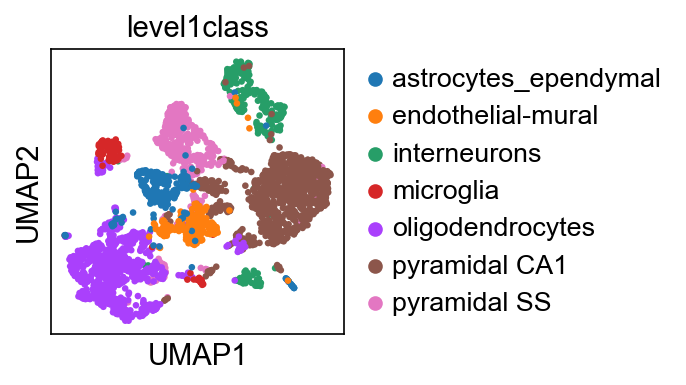

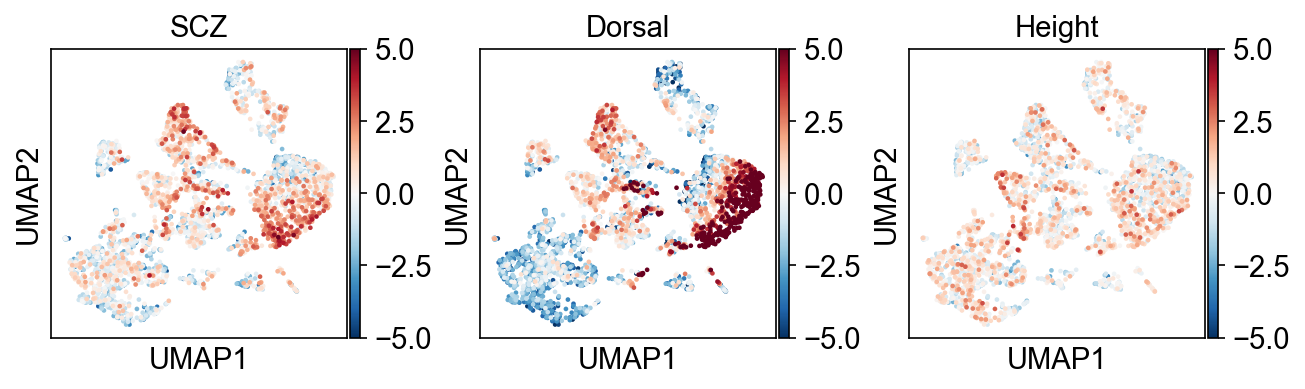

In [5]:
dict_score = {
    trait: pd.read_csv(f"data/{trait}.full_score.gz", sep="\t", index_col=0)
    for trait in df_gs.index
}

for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

sc.set_figure_params(figsize=[2.5, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color="level1class",
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

sc.pl.umap(
    adata,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
)

We highlight several visual observations:

1. In the SCZ panel, CA1 pyramidal neurons shows some disease enrichments.  
2. In the Dorsal panel, within the CA pyramidal neurons, we observe left-to-right gradient of Dorsal score, which indicates that cells on the right of the UMAP are enriched in dorsal area of CA1.
3. Combining SCZ and Dorsal panels, we may hypothesize that SCZ is enriched in dorsal part of CA1.
4. Height, as a negative control, shows little signal.

Before we dive into detailed analyses, it is helpful to first leverage existing annotations in the data set to understand the data. 

We use the `level1class` annotation provided in Zeisel & Muñoz-Manchado et al. 2015 to first perform a cell type level analyses.

# `scDRS` test of group level statistics

`scDRS` provide `scdrs.util.group_stats` to obtain the group-level statistics. The function will return the following statistics for each cell type:

1. `fdr_prop`: the proportion of significantly associated cells (FDR$<$0.1 across all cells for a given disease)
2. `assoc_pval`: significance of cell type-disease association
3. `hetero_pval`: significance heterogeneity in association with disease across individual cells within a given cell type

In [6]:
%%capture

for trait in ["SCZ", "Height"]:
    !scdrs perform-downstream \
        --h5ad-file data/expr.h5ad \
        --score-file data/{trait}.full_score.gz \
        --out-folder data/ \
        --group-analysis level1class \
        --flag-filter-data True \
        --flag-raw-count True

In [7]:
# scDRS group-level statistics for SCZ
!cat data/SCZ.scdrs_group.level1class | column -t -s $'\t'

group                 n_cell  n_ctrl  assoc_mcp    assoc_mcz    hetero_mcp   hetero_mcz  n_fdr_0.05  n_fdr_0.1  n_fdr_0.2
astrocytes_ependymal  224.0   1000.0  0.007992008  2.755896     0.002997003  3.0352552   6.0         12.0       23.0
endothelial-mural     235.0   1000.0  0.14085914   1.0441228    0.051948052  1.8254294   6.0         9.0        11.0
interneurons          290.0   1000.0  0.17982018   0.85168266   0.005994006  3.0294392   0.0         3.0        13.0
microglia             98.0    1000.0  0.43956044   0.09781444   0.17782217   0.9301765   0.0         2.0        3.0
oligodendrocytes      820.0   1000.0  0.7672328    -0.73165476  0.000999001  5.0373654   1.0         4.0        11.0
pyramidal CA1         939.0   1000.0  0.000999001  7.7077475    0.000999001  9.697396    50.0        105.0      189.0
pyramidal SS          399.0   1000.0  0.000999001  5.78891      0.000999001  6.059032    26.0        43.0       70.0


We can also visualize the three statistics simulateously using the built-in `scdrs.util.plot_group_stats`:

1. Heatmap colors for each cell type-disease pair denote the proportion of significantly associated cells.
2. Squares denote significant cell type-disease associations (FDR$<$0.05 across all pairs of cell types and diseases/traits.
3. Cross symbols denote significant heterogeneity in association with disease across individual cells within a given cell type.

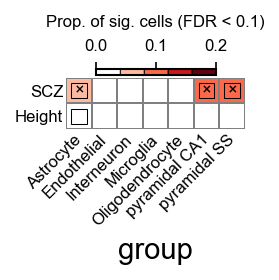

In [8]:
dict_df_stats = {
    trait: pd.read_csv(f"data/{trait}.scdrs_group.level1class", sep="\t", index_col=0)
    for trait in ["SCZ", "Height"]
}
dict_celltype_display_name = {
    "pyramidal_CA1": "Pyramidal CA1",
    "oligodendrocytes": "Oligodendrocyte",
    "pyramidal_SS": "Pyramidal SS",
    "interneurons": "Interneuron",
    "endothelial-mural": "Endothelial",
    "astrocytes_ependymal": "Astrocyte",
    "microglia": "Microglia",
}

scdrs.util.plot_group_stats(
    {
        trait: df_stats.rename(index=dict_celltype_display_name)
        for trait, df_stats in dict_df_stats.items()
    }
)

We observed that CA1 pyramidal neurons show the strongest cell type association as well as significant heterogeneity.

Now we focus on this subset of cells and further understand sources of heterogeneity.

In [9]:
# extract CA1 pyramidal neurons and perform a re-clustering
adata_ca1 = adata[adata.obs["level2class"].isin(["CA1Pyr1", "CA1Pyr2"])].copy()
sc.pp.filter_cells(adata_ca1, min_genes=0)
sc.pp.filter_genes(adata_ca1, min_cells=1)
sc.pp.normalize_total(adata_ca1, target_sum=1e4)
sc.pp.log1p(adata_ca1)

sc.pp.highly_variable_genes(adata_ca1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_ca1 = adata_ca1[:, adata_ca1.var.highly_variable]
sc.pp.scale(adata_ca1, max_value=10)
sc.tl.pca(adata_ca1, svd_solver="arpack")

sc.pp.neighbors(adata_ca1, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_ca1, n_components=2)

# assign scDRS score
for trait in dict_score:
    adata_ca1.obs[trait] = dict_score[trait]["norm_score"]

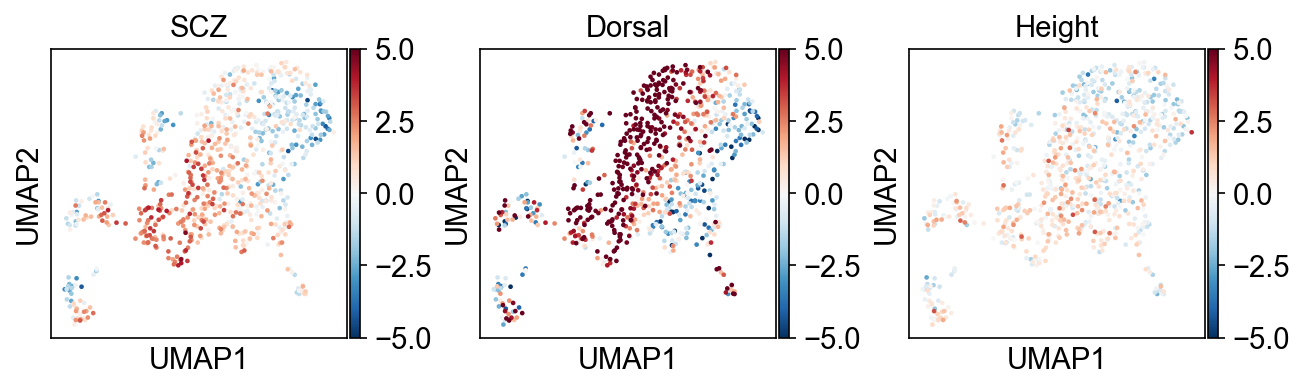

In [10]:
sc.pl.umap(
    adata_ca1,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
)

# `scDRS` test between disease score and cell-level variable

Consistent with the previous observations, SCZ seems to be enriched in dorsal part of CA1.

This is more obvious when we plot the plot average SCZ disease score against dorsal quintile.

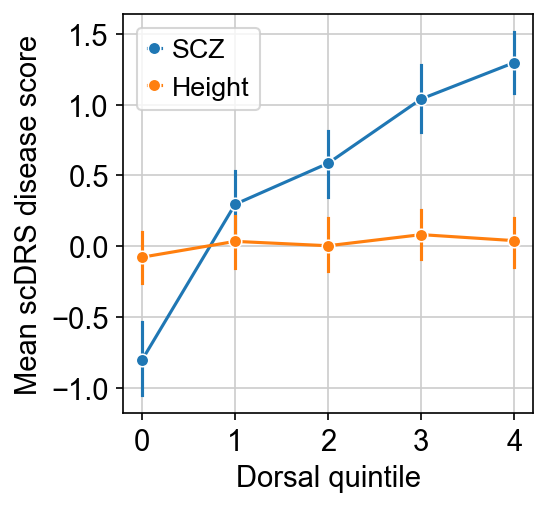

In [11]:
df_plot = adata_ca1.obs[["Dorsal", "SCZ", "Height"]].copy()
df_plot["Dorsal quintile"] = pd.qcut(df_plot["Dorsal"], 5, labels=np.arange(5))

fig, ax = plt.subplots(figsize=(3.5, 3.5))
for trait in ["SCZ", "Height"]:
    sns.lineplot(
        data=df_plot,
        x="Dorsal quintile",
        y=trait,
        label=trait,
        err_style="bars",
        marker="o",
        ax=ax,
    )
ax.set_xticks(np.arange(5))
ax.set_xlabel("Dorsal quintile")
ax.set_ylabel("Mean scDRS disease score")
fig.show()

To perform rigorous statistical test which quantify the p-value of the trend (probability that this happens by chance).

We can compare Pearson's correlation of disease score and dorsal score against Pearson's correlation of control scores and dorsal score and derive a p-value.

Indeed, the association between SCZ v.s. Dorsal is highly significant.

In [12]:
spatial_col = "Dorsal"
for trait in ["SCZ", "Height"]:
    df_score = dict_score[trait].reindex(adata_ca1.obs.index)
    ctrl_cols = [col for col in df_score.columns if col.startswith("ctrl_norm_score")]
    n_ctrl = len(ctrl_cols)

    # Pearson's r between trait score and spatial score
    data_r = stats.pearsonr(df_score["norm_score"], adata_ca1.obs[spatial_col])[0]

    # Regression: control score ~ spatial score
    ctrl_r = np.zeros(len(ctrl_cols))
    for ctrl_i, ctrl_col in enumerate(ctrl_cols):
        ctrl_r[ctrl_i] = stats.pearsonr(df_score[ctrl_col], adata_ca1.obs[spatial_col])[
            0
        ]
    pval = (np.sum(data_r <= ctrl_r) + 1) / (n_ctrl + 1)

    print(f"{trait} v.s. {spatial_col}, Pearson's r={data_r:.2g} (p={pval:.2g})")

SCZ v.s. Dorsal, Pearson's r=0.43 (p=0.001)
Height v.s. Dorsal, Pearson's r=0.04 (p=0.37)
